# Overview
Do you scan online retailers in search of the best deals? You're joined by the many savvy shoppers who don't like paying extra for the same product depending on where they shop. Retail companies use a variety of methods to assure customers that their products are the cheapest. Among them is product matching, which allows a company to offer products at rates that are competitive to the same product sold by another retailer. To perform these matches automatically requires a thorough machine learning approach, which is where your data science skills could help.

Two different images of similar wares may represent the same product or two completely different items. Retailers want to avoid misrepresentations and other issues that could come from conflating two dissimilar products. Currently, a combination of deep learning and traditional machine learning analyzes image and text information to compare similarity. But major differences in images, titles, and product descriptions prevent these methods from being entirely effective.

Shopee is the leading e-commerce platform in Southeast Asia and Taiwan. Customers appreciate its easy, secure, and fast online shopping experience tailored to their region. The company also provides strong payment and logistical support along with a 'Lowest Price Guaranteed' feature on thousands of Shopee's listed products.

In this competition, you’ll apply your machine learning skills to build a model that predicts which items are the same products.

The applications go far beyond Shopee or other retailers. Your contributions to product matching could support more accurate product categorization and uncover marketplace spam. Customers will benefit from more accurate listings of the same or similar products as they shop. Perhaps most importantly, this will aid you and your fellow shoppers in your hunt for the very best deals.


# Purpose
Finding near-duplicates in large datasets is an important problem for many online businesses. In Shopee's case, everyday users can upload their own images and write their own product descriptions, adding an extra layer of challenge. **Your task is to identify which products have been posted repeatedly.** The differences between related products may be subtle while photos of identical products may be wildly different!


# Data Description
`[train/test].csv` - the training set metadata. Each row contains the data for a single posting. Multiple postings might have the exact same image ID, but with different titles or vice versa.

`posting_id` - the ID code for the posting.

`image` - the image id/md5sum.

`image_phash` - a perceptual hash of the image.

`title` - the product description for the posting.

`label_group` - ID code for all postings that map to the same product. Not provided for the test set.

`[train/test]images` - the images associated with the postings.

# Setup GPU parameters

In [ ]:
# RESTRICT TENSORFLOW TO 2GB OF GPU RAM
# SO THAT WE HAVE 14GB RAM FOR RAPIDS

import tensorflow as tf

LIMIT = 2.0
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*LIMIT)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        #print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
print('We will restrict TensorFlow to max %iGB GPU RAM'%LIMIT)
print('then RAPIDS can use %iGB GPU RAM'%(16-LIMIT))

We will restrict TensorFlow to max 2GB GPU RAM
then RAPIDS can use 14GB GPU RAM


# Import dataset from Kaggle

In [ ]:
# install Kaggle on goggle colab
!pip install -q kaggle

In [1]:
from google.colab import files

files.upload() # import user API from kaggle

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"emilsagre","key":"59587c0ef9f7b2adf1f0e8a20a617218"}'}

In [2]:
# create kaggle folder
! mkdir ~/.kaggle

In [3]:
# copy the kaggle.json folder created
! cp kaggle.json ~/.kaggle/

In [4]:
# permission for the json to act
! chmod 600 ~/.kaggle.json

chmod: cannot access '/root/.kaggle.json': No such file or directory


In [ ]:
# list all dataset in kaggle

## ! kaggle datasets list

In [5]:
!kaggle competitions download -c shopee-product-matching

 99% 1.67G/1.68G [00:11<00:00, 165MB/s]
100% 1.68G/1.68G [00:12<00:00, 150MB/s]


In [6]:
# unzip files
!unzip shopee-product-matching.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_images/d8fce6d90ff1c758810b2132d8d9a84e.jpg  
  inflating: train_images/d90143423d8db45b382f2dee3d01fcb1.jpg  
  inflating: train_images/d903b2ab37c0418bfeb7e6e5304b64a4.jpg  
  inflating: train_images/d905748b1f61121cdcc7ae397b97052b.jpg  
  inflating: train_images/d906df4fdf70397d4f04ef0fe6ea1fe2.jpg  
  inflating: train_images/d9074f43948053971953322ed8ddc2cf.jpg  
  inflating: train_images/d9076a1375bb05c33edd5a1f1684e1f0.jpg  
  inflating: train_images/d9093fbb00a2013aad7cbcd993d779ab.jpg  
  inflating: train_images/d90ac3ff5b7d6371c50b3ef737002084.jpg  
  inflating: train_images/d90c105714e1475c4ef930e796570749.jpg  
  inflating: train_images/d90e64bea620d6e38ffe9f35b276c192.jpg  
  inflating: train_images/d9149fbfdf8d8d197f86e0a3d2ab7584.jpg  
  inflating: train_images/d914f6199e2dbafdd4a519c48dd1a5f4.jpg  
  inflating: train_images/d9159234afcf810fa9ddc7b2d49ce707.jpg  
  inflating: train_images/d91635194d9f9

# Text Analysis

## Read dataset

In [7]:
# Data processing
import pandas as pd
import numpy as np

In [8]:
# import csv train dataset
train_csv = pd.read_csv('train.csv', encoding = 'latin-1')
train_csv

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069
...,...,...,...,...,...
34245,train_4028265689,fff1c07ceefc2c970a7964cfb81981c5.jpg,e3cd72389f248f21,Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...,3776555725
34246,train_769054909,fff401691371bdcb382a0d9075dfea6a.jpg,be86851f72e2853c,MamyPoko Pants Royal Soft - S 70 - Popok Celana,2736479533
34247,train_614977732,fff421b78fa7284284724baf249f522e.jpg,ad27f0d08c0fcbf0,KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Me...,4101248785
34248,train_3630949769,fff51b87916dbfb6d0f8faa01bee67b8.jpg,e3b13bd1d896c05c,"Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...",1663538013


In [9]:
# check dimensions
print("training df:", len(train_csv))

print("unique label:", train_csv["label_group"].nunique())

training df: 34250
unique label: 11014


In [10]:
seed = 123 # value of seed for sampling

## Exploratory Data Analysis

In [11]:
# check for NAs
train_csv.isna().sum()

posting_id     0
image          0
image_phash    0
title          0
label_group    0
dtype: int64

In [12]:
# count of image per label_group
a = train_csv.groupby(["label_group"]).size().reset_index(name = "freq") # label_group per freq
a = a.sort_values(by = 'freq', ascending = False) # sort from highest to lowest freq
a.sample(10, random_state = seed)

,label_group,freq
1252,493495643,2
4367,1706134941,3
4766,1868756563,2
8910,3455379718,2
4250,1664980565,2
1030,401991387,2
2439,936668906,2
5537,2154345913,5
1512,582084093,2
8214,3177197131,3


In [13]:
a.head(10)

,label_group,freq
3041,1163569239,51
412,159351600,51
2606,994676122,51
8037,3113678103,51
9370,3627744656,51
2994,1141798720,51
1445,562358068,51
8297,3206118280,49
4438,1733221456,46
3047,1166650192,46


In [14]:
train_csv.loc[train_csv['label_group'] == 1163569239].head(10) # sample label_group

,posting_id,image,image_phash,title,label_group
1088,train_1671347582,089060edc61ec626e6b4943cf18dd651.jpg,e38c9933a571a627,SCARLETT SERUM - BEBAS PILIH,1163569239
1365,train_1175819799,0ad5228fee2f95f68253719c32fc4f5b.jpg,bf93c06c67901763,SCARLETT WHITENING ACNE SERUM,1163569239
1889,train_1525859862,0e9286fbfd1a0c00287c2c93a4738b9a.jpg,f956c679d5d410d0,SERUM SCARLETT ACNE & BRIGHTLY- SERUM WAJAH SC...,1163569239
1932,train_1261404451,0ee29d56042b2ff25d171b0f090463a8.jpg,b62c2bc37b5e1486,Scarlett Whitening Brightly Ever After Serum,1163569239
2223,train_1865413913,11007ac5a612addbb5df96445e438b14.jpg,bbcb16f01ae0039f,SCARLETT serum wajah NEW,1163569239
2822,train_943427380,158ac22bf48f9c2edfde81e2502af076.jpg,f9565739d5c450c4,SERUM SCARLETT ACNE & BRIGHTLY- FACE SERUM ORI...,1163569239
4111,train_3789517483,1f54f4cee1e5c094b00e0e423971f283.jpg,bbcb16f01ae0039f,SCARLETT Whitening Brightly Ever After Serum /...,1163569239
5343,train_3171223531,286db00383814bfdb2191d7a9dee6d22.jpg,e6d1992eea898966,SCARLETT WHITENING BRIGHTLY EVER AFTER SERUM,1163569239
7558,train_623546295,3907af8ee31d85d32ddaf03a067099ad.jpg,e79c93632472c66c,SCARLETT ACNE SERUM & BRIGHTLY EVER AFTER SERUM,1163569239
7576,train_3598710032,3922820f64ae0759bdd2a3e44e5466da.jpg,e59c9b63a472c62c,Scarlett Serum,1163569239


<Figure size 1440x720 with 0 Axes>

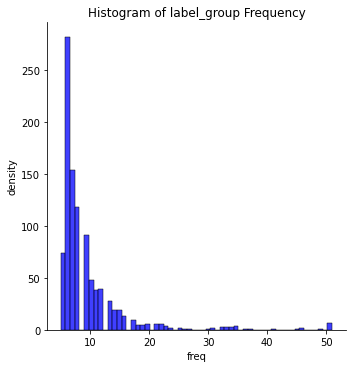

In [15]:
# plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 10))
sns.displot(a["freq"][:1000], color = 'blue')
plt.ylabel("density")
plt.title("Histogram of label_group Frequency")
plt.show()

In [16]:
# check summary of statistics
a.describe(percentiles=[0.25, 0.5, 0.75, 0.8, 0.99])

,label_group,freq
count,1.101400e+04,11014.000000
mean,2.138621e+09,3.109679
std,1.235108e+09,2.940827
min,2.580470e+05,2.000000
25%,1.054134e+09,2.000000
50%,2.141621e+09,2.000000
75%,3.192278e+09,3.000000
80%,3.421221e+09,4.000000
99%,4.251806e+09,14.000000
max,4.294197e+09,51.000000


In [17]:
# check character length per observations
train_csv ['length'] = train_csv['title'].apply(len)
train_csv

,posting_id,image,image_phash,title,label_group,length
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,25
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,60
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,43
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,98
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,33
...,...,...,...,...,...,...
34245,train_4028265689,fff1c07ceefc2c970a7964cfb81981c5.jpg,e3cd72389f248f21,Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...,3776555725,67
34246,train_769054909,fff401691371bdcb382a0d9075dfea6a.jpg,be86851f72e2853c,MamyPoko Pants Royal Soft - S 70 - Popok Celana,2736479533,47
34247,train_614977732,fff421b78fa7284284724baf249f522e.jpg,ad27f0d08c0fcbf0,KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Me...,4101248785,63
34248,train_3630949769,fff51b87916dbfb6d0f8faa01bee67b8.jpg,e3b13bd1d896c05c,"Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...",1663538013,88


In [18]:
# check summary of statistics
train_csv.length.describe()

count    34250.000000
mean        56.163474
std         25.100492
min          5.000000
25%         36.000000
50%         53.000000
75%         73.000000
max        357.000000
Name: length, dtype: float64

In [19]:
# average length is around 56 characters

In [20]:
# visualization
import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
# word cloud visualization
from wordcloud import WordCloud
from PIL import Image

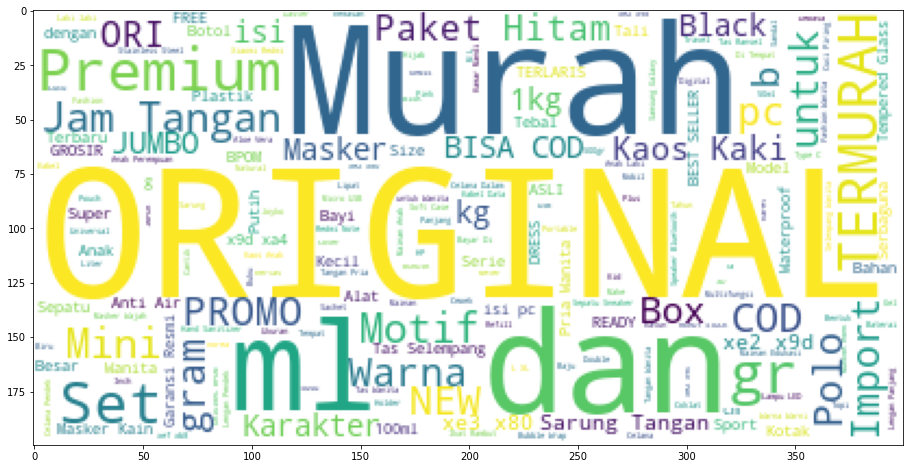

In [22]:
# plot
wc = WordCloud (
    background_color = 'white',
    max_words = 200,
    # random_state = seed,
    max_font_size = 100
)

wc.generate(' '.join(train_csv['title']))
plt.figure(figsize = (20,8))
plt.imshow(wc)
plt.show()

In [23]:
# top common words were: ORIGINAL, Murah, dan, Set, ml, Premium

## Preprocessing

In [24]:
# Import stopwords and reference corpus
import nltk
nltk.download('stopwords')

import gensim
from gensim import corpora, models

import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [25]:
# set stopwords per language
stopwords_eng = nltk.corpus.stopwords.words('english')
stopwords_ind = nltk.corpus.stopwords.words('indonesian')

In [26]:
# define function to remove stop words and common special characters
def textpreprocessing(text):
    text = text.strip() # remove trailing and leading characters
    text = text.lower() # convert to lower cases
    punctuations = r'[/\,\-!@%#$^&*|_+)(:]'
    
    text = re.sub(punctuations, '', text)
    string=""
    for word in text.split():
        if not word in stopwords_eng: # remove stop words in english
          if not word in stopwords_ind: # remove stop words in indonesian
           string += word + " "
    return string.strip()


In [27]:
train_csv['title_clean'] = train_csv['title'].map(textpreprocessing) # create column without stop words and common special character
train_csv

,posting_id,image,image_phash,title,label_group,length,title_clean
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,25,paper bag victoria secret
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,60,double tape 3m vhb 12 mm x 45 original double ...
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,43,maling tts canned pork luncheon meat 397 gr
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,98,daster batik lengan pendek motif acak campur l...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,33,nescafe \xc3\x89clair latte 220ml
...,...,...,...,...,...,...,...
34245,train_4028265689,fff1c07ceefc2c970a7964cfb81981c5.jpg,e3cd72389f248f21,Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...,3776555725,67,masker bahan kain spunbond non woven 75 gsm 3 ...
34246,train_769054909,fff401691371bdcb382a0d9075dfea6a.jpg,be86851f72e2853c,MamyPoko Pants Royal Soft - S 70 - Popok Celana,2736479533,47,mamypoko pants royal soft 70 popok celana
34247,train_614977732,fff421b78fa7284284724baf249f522e.jpg,ad27f0d08c0fcbf0,KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Me...,4101248785,63,khanzaacc robot re101s 1.2mm subwoofer bass me...
34248,train_3630949769,fff51b87916dbfb6d0f8faa01bee67b8.jpg,e3b13bd1d896c05c,"Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...",1663538013,88,kaldu non msg halal mama ayam kampung sapi lok...


In [28]:
train_csv['title_clean'].unique() # checking

array(['paper bag victoria secret',
       'double tape 3m vhb 12 mm x 45 original double foam tape',
       'maling tts canned pork luncheon meat 397 gr', ...,
       'khanzaacc robot re101s 1.2mm subwoofer bass metal wired headset',
       'kaldu non msg halal mama ayam kampung sapi lokal jamur bkn alsultan biocell',
       'flex tape pelapis bocor isolasi ajaib anti bocor'], dtype=object)

In [29]:
print("Number of unique title_clean:", train_csv['title_clean'].nunique())
print("Number of unique label_group:",train_csv['label_group'].nunique())

Number of unique title_clean: 32423
Number of unique label_group: 11014


In [30]:
# check character length per observations for title_clean
train_csv ['length_clean'] = train_csv['title_clean'].apply(len)
train_csv

,posting_id,image,image_phash,title,label_group,length,title_clean,length_clean
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,25,paper bag victoria secret,25
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,60,double tape 3m vhb 12 mm x 45 original double ...,55
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,43,maling tts canned pork luncheon meat 397 gr,43
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,98,daster batik lengan pendek motif acak campur l...,89
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,33,nescafe \xc3\x89clair latte 220ml,33
...,...,...,...,...,...,...,...,...
34245,train_4028265689,fff1c07ceefc2c970a7964cfb81981c5.jpg,e3cd72389f248f21,Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...,3776555725,67,masker bahan kain spunbond non woven 75 gsm 3 ...,62
34246,train_769054909,fff401691371bdcb382a0d9075dfea6a.jpg,be86851f72e2853c,MamyPoko Pants Royal Soft - S 70 - Popok Celana,2736479533,47,mamypoko pants royal soft 70 popok celana,41
34247,train_614977732,fff421b78fa7284284724baf249f522e.jpg,ad27f0d08c0fcbf0,KHANZAACC Robot RE101S 1.2mm Subwoofer Bass Me...,4101248785,63,khanzaacc robot re101s 1.2mm subwoofer bass me...,63
34248,train_3630949769,fff51b87916dbfb6d0f8faa01bee67b8.jpg,e3b13bd1d896c05c,"Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...",1663538013,88,kaldu non msg halal mama ayam kampung sapi lok...,75


In [31]:
# check summary of statistics
train_csv.length_clean.describe()

count    34250.000000
mean        52.716263
std         23.579816
min          0.000000
25%         35.000000
50%         49.000000
75%         68.000000
max        356.000000
Name: length_clean, dtype: float64

In [32]:
# mean length reduced from 56 to 52

### Word Cloud

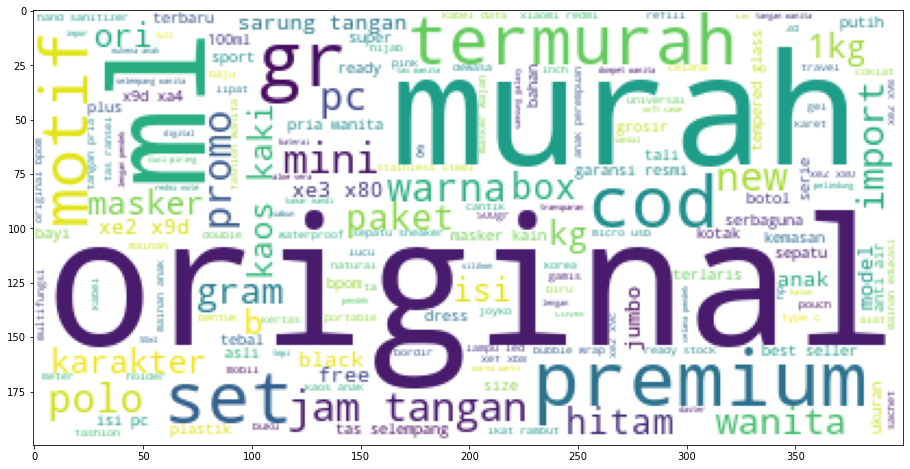

In [33]:
# plot word cloud
wc_clean = WordCloud (
    background_color = 'white',
    max_words = 200,
    # random_state = seed,
    max_font_size = 100
)

wc_clean.generate(' '.join(train_csv['title_clean']))
plt.figure(figsize = (20,8))
plt.imshow(wc_clean)
plt.show()

In [34]:
# top common words were: original, murah, ml, premium, cod

# indonesian stopword dan was removed as common word

In [35]:
import collections
from collections import Counter

In [36]:
# define function to plot most common words 
def wordBarGraphFunction(df,column,title):
    # sw_ind = nltk.corpus.stopwords.words('indonesian')
    topic_words = [ z.lower() for y in
                       [ x.split() for x in df[column] if isinstance(x, str)]
                       for z in y]
    word_count_dict = dict(Counter(topic_words))
    popular_words = sorted(word_count_dict, key = word_count_dict.get, reverse = True)
    # popular_words_nonstop = [w for w in popular_words if w not in sw_ind]
    plt.barh(range(50), [word_count_dict[w] for w in reversed(popular_words[0:50])])
    plt.yticks([x + 0.5 for x in range(50)], reversed(popular_words[0:50]))
    plt.title(title)
    plt.show()

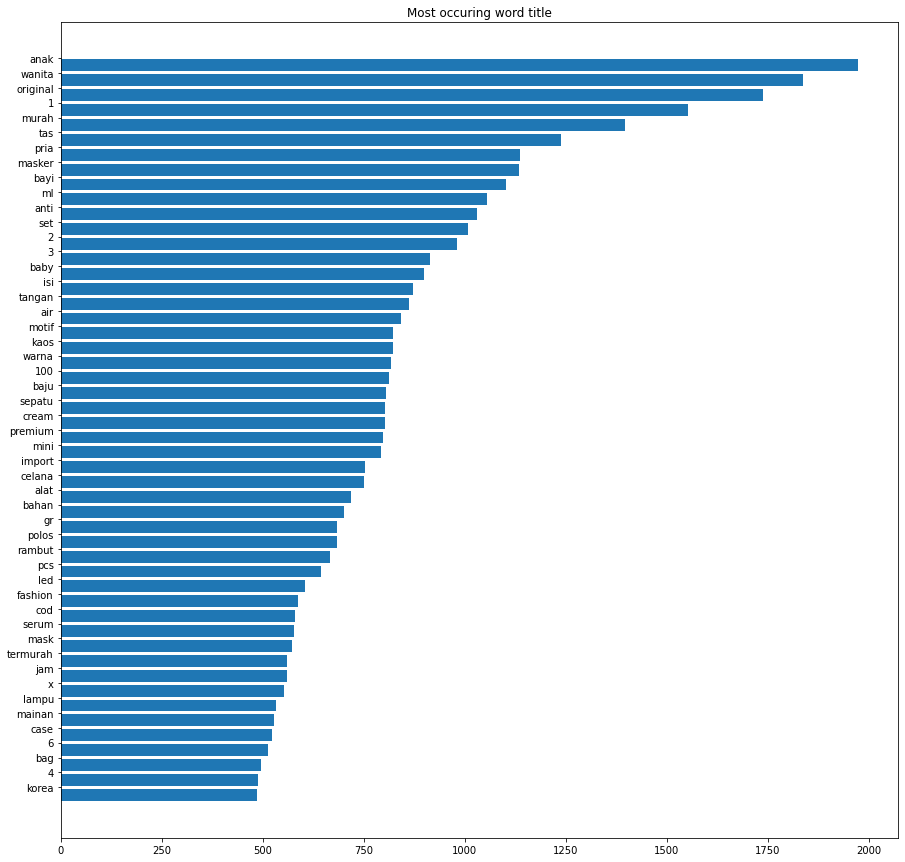

In [37]:
plt.figure(figsize = (15,15))
wordBarGraphFunction(train_csv,'title_clean', "Most occuring word title")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code_obj, self.user_global_ns, self.user_ns)


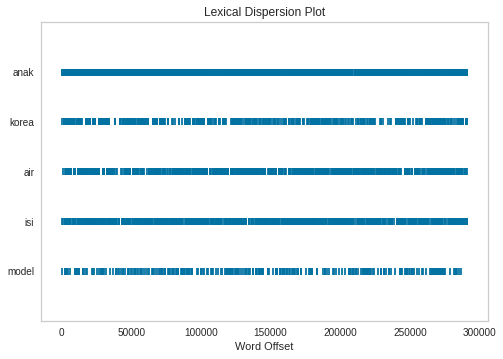

In [38]:
from yellowbrick.text import DispersionPlot

# Create a list of words from the corpus text
text = [doc.split() for doc in train_csv['title_clean']]

# Choose words whose occurence in the text will be plotted
target_words = ['anak', 'korea', 'air', 'isi', 'model'] # random words

# Create the visualizer and draw the plot
visualizer = DispersionPlot(target_words)
visualizer.fit(text)
visualizer.show()

In [39]:
print(text)

Output hidden; open in https://colab.research.google.com to view.

### Interactive Word Distance Map

In [40]:
# create dictionary of tokens
dictionary = corpora.Dictionary(text) # text contains list of arrays of words
print(dictionary)

Dictionary(29549 unique tokens: ['bag', 'paper', 'secret', 'victoria', '12']...)


In [41]:
bow_text = [dictionary.doc2bow(txt) for txt in text] # bag of words
print(bow_text)

Output hidden; open in https://colab.research.google.com to view.

In [42]:
# ! pip install pyLDAvis

import pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=b52304352919085740661552d518bf953fd6324ff19036c66c40d2059f1c7ea8
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [43]:
from gensim import models
import pyLDAvis.gensim_models as gensimvis

In [44]:
# create tfidf model
tfidf_model = models.TfidfModel(bow_text)
tfidf_text = tfidf_model[bow_text]

# LDA model
lda = models.LdaMulticore(tfidf_text, num_topics = 20, id2word = dictionary, passes = 2, workers = 2)

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for

In [45]:
pyLDAvis.enable_notebook()
visual = gensimvis.prepare(lda, tfidf_text, dictionary)
visual

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
9      0.017997 -0.075627       1        1  5.467295
6      0.028407 -0.052172       2        1  5.423103
2      0.056162  0.032702       3        1  5.319601
12    -0.032801  0.053206       4        1  5.291889
18    -0.050470 -0.011976       5        1  5.233477
11    -0.068973 -0.131182       6        1  5.214799
13     0.066820 -0.002236       7        1  5.190916
5     -0.169947  0.063877       8        1  5.159912
7      0.004857 -0.048790       9        1  5.128612
15     0.075592  0.005612      10        1  5.048129
8     -0.016719 -0.068087      11        1  4.997263
3     -0.002875 -0.068707      12        1  4.953427
17     0.009929 -0.084410      13        1  4.901440
4     -0.128370  0.055508      14        1  4.862494
16     0.063160  0.038957      15        1  4.849611
10     0.039495  0.114721      16        1  4.756988
1     -0.043156  0.068815      17        1  4.577593
0      0.040385  0.036771      18        1  4.570131
19     0.069458  0.071834      19        1  4.564227
14     0.041049  0.001185      20        1  4.489091, topic_info=           Term        Freq       Total Category  logprob  loglift
500         tas  178.000000  178.000000  Default  30.0000  30.0000
1156  bluetooth   62.000000   62.000000  Default  29.0000  29.0000
256         jam   90.000000   90.000000  Default  28.0000  28.0000
285        kaos  124.000000  124.000000  Default  27.0000  27.0000
260      tangan  131.000000  131.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
199        bayi   12.125580  148.636171  Topic20  -5.8090   0.5973
1677          c   10.058137   52.987338  Topic20  -5.9960   1.4418
399       serum   10.895755  108.597352  Topic20  -5.9160   0.8042
90            2   10.829191  133.521584  Topic20  -5.9221   0.5915
45         anak   10.320134  235.331552  Topic20  -5.9703  -0.0234

[1356 rows x 6 columns], token_table=       Topic      Freq    Term
term                          
7092       6  0.808892       .
7092       9  0.115556       .
6349       8  0.876218     0.5
238        1  0.048246       1
238        2  0.069689       1
...      ...       ...     ...
1408       7  0.213124  zaitun
1408      18  0.071041  zaitun
16951     19  0.841568   zeera
13148     13  0.826713  zernii
1861      17  0.851883       ~

[4952 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[10, 7, 3, 13, 19, 12, 14, 6, 8, 16, 9, 4, 18, 5, 17, 11, 2, 1, 20, 15])

In [46]:
len(tfidf_text)

34250

### TF-IDF Vector dataframe

In [47]:
pd.DataFrame(tfidf_text) # number of words with corresponding relevance score

,0,1,2,3,4,5,6,7,8,9,...,46,47,48,49,50,51,52,53,54,55
0,"(0, 0.32018984175053766)","(1, 0.4383717653237234)","(2, 0.5154828220394698)","(3, 0.6630129114798236)",None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,"(4, 0.2060327671670019)","(5, 0.30755121571313476)","(6, 0.2776854453547432)","(7, 0.4613423636009526)","(8, 0.25392168144753097)","(9, 0.26245265725548994)","(10, 0.1321945532050627)","(11, 0.49286203892364366)","(12, 0.3813549986682362)","(13, 0.18395413456671242)",...,None,None,None,None,None,None,None,None,None,None
2,"(14, 0.42013779464022555)","(15, 0.3922472664774388)","(16, 0.15836113502309418)","(17, 0.3922472664774388)","(18, 0.31117255245447967)","(19, 0.3274874655550172)","(20, 0.3643567383146521)","(21, 0.3922472664774388)",None,None,...,None,None,None,None,None,None,None,None,None,None
3,"(22, 0.30523455457468973)","(23, 0.3620652619558914)","(24, 0.4844623191192303)","(25, 0.31189696768494213)","(26, 0.22881716774822639)","(27, 0.3545910462813271)","(28, 0.25104958385119314)","(29, 0.1789867437127935)","(30, 0.26451650619266537)","(31, 0.2021880038679983)",...,None,None,None,None,None,None,None,None,None,None
4,"(34, 0.5204172381357143)","(35, 0.6000903173479294)","(36, 0.42511559037280705)","(37, 0.4339749348734746)",None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34245,"(194, 0.16875250424082766)","(196, 0.17107134176985436)","(301, 0.17954971860412405)","(1131, 0.20296754316499446)","(1183, 0.2681068662558131)","(1513, 0.24496640148618593)","(1514, 0.28180286523522924)","(3872, 0.31189426701394807)","(4317, 0.42992423751435177)","(5645, 0.34262543171125726)",...,None,None,None,None,None,None,None,None,None,None
34246,"(40, 0.2629086486308099)","(349, 0.312766035291007)","(713, 0.33968076134549713)","(829, 0.4464099657636852)","(1112, 0.437170343778545)","(1114, 0.3965783277751352)","(1115, 0.4123097051267419)",None,None,None,...,None,None,None,None,None,None,None,None,None,None
34247,"(309, 0.22026941569385067)","(793, 0.325707907146513)","(818, 0.25598564325313955)","(846, 0.24219820648104462)","(1023, 0.35064815902194474)","(1045, 0.37915059098954895)","(1086, 0.2942791635851364)","(17724, 0.37915059098954895)","(29546, 0.4734368216736788)",None,...,None,None,None,None,None,None,None,None,None,None
34248,"(839, 0.2447265882673618)","(1029, 0.20898966209326342)","(1304, 0.22709742196580593)","(1466, 0.2447265882673618)","(1513, 0.18996849228471951)","(3659, 0.2058543089928448)","(4408, 0.2337247818969734)","(6116, 0.24783160967477144)","(8376, 0.33340106521450735)","(11153, 0.34787018275052295)",...,None,None,None,None,None,None,None,None,None,None


In [48]:
from gensim import matutils

In [49]:
# transform corpus to tfidf vector
x_tfidf_vector = gensim.interfaces.TransformedCorpus(tfidf_model, bow_text)
x_tfidf = matutils.corpus2csc(x_tfidf_vector)
x_features = pd.DataFrame(x_tfidf.toarray()).transpose()
x_features

,0,1,2,3,4,5,6,7,8,9,...,29539,29540,29541,29542,29543,29544,29545,29546,29547,29548
0,0.32019,0.438372,0.515483,0.663013,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,0.00000,0.000000,0.000000,0.000000,0.206033,0.307551,0.277685,0.461342,0.253922,0.262453,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34245,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
34246,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
34247,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.473437,0.000000,0.000000
34248,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.372605,0.372605


In [50]:
from sys import getsizeof
getsizeof(x_features) # 8gb

8096426160

## Similarity Classification

In [51]:
# from sklearn.model_selection import train_test_split

# splitting into training and testing
# X_train, X_test, y_train, y_test = train_test_split(x_features, 
#                                                     train_csv['label_group'], 
#                                                     test_size=0.20, 
#                                                     random_state=seed)


In [ ]:
# reduce dimensions to 95%
from sklearn.decomposition import PCA
pca = PCA(0.90)
pca.fit(x_features)